In [1]:
import os
import tensorflow as tf
from tensorflow.contrib import eager as tfe
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# static graphs still don't work well with eager :(
# tf.enable_eager_execution()

In [2]:
sess = tf.Session()

In [3]:
CV_MODEL = 'faster_rcnn_resnet50_coco_2018_01_28'
MODEL_PATH = os.path.join(os.environ['HOME'], "models", CV_MODEL)
os.listdir(MODEL_PATH)

['pipeline.config',
 'model.ckpt.meta',
 'checkpoint',
 'model.ckpt.index',
 'saved_model',
 'model.ckpt.data-00000-of-00001',
 'frozen_inference_graph.pb']

In [4]:
saver = tf.train.import_meta_graph(os.path.join(MODEL_PATH, 'model.ckpt.meta'))
saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))

W0405 20:28:55.238688 139635147732800 deprecation.py:323] From /home/reddi-rtx/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [5]:
[v for v in tf.get_default_graph().as_graph_def().node
        if "Placeholder" in v.op]
[v for v in tf.get_default_graph().as_graph_def().node
        if "detection" in v.name]

[name: "detection_boxes"
 op: "Identity"
 input: "SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayStack/TensorArrayGatherV3"
 attr {
   key: "T"
   value {
     type: DT_FLOAT
   }
 }, name: "detection_scores"
 op: "Identity"
 input: "SecondStagePostprocessor/BatchMultiClassNonMaxSuppression/map/TensorArrayStack_1/TensorArrayGatherV3"
 attr {
   key: "T"
   value {
     type: DT_FLOAT
   }
 }, name: "detection_classes"
 op: "Identity"
 input: "add"
 attr {
   key: "T"
   value {
     type: DT_FLOAT
   }
 }, name: "num_detections"
 op: "Identity"
 input: "SecondStagePostprocessor/ToFloat_1"
 attr {
   key: "T"
   value {
     type: DT_FLOAT
   }
 }]

In [6]:
graph = tf.get_default_graph()

In [7]:
input_tensor = graph.get_tensor_by_name('image_tensor:0')
output_tensors = dict(
    bboxes = graph.get_tensor_by_name('detection_boxes:0'),
    classes = graph.get_tensor_by_name('detection_classes:0'),
    n = graph.get_tensor_by_name('num_detections:0'),
    scores = graph.get_tensor_by_name('detection_scores:0'),
)

### Load test video

Videos are usually in the `~/videos` directory.

In [8]:
import cv2
VIDEO_PATH = os.path.join(os.environ["HOME"], "videos")
cap = cv2.VideoCapture(os.path.join(VIDEO_PATH, 'scicenplaza_test.mkv'))

In [9]:
for _ in range(1000):
    cap.read()
    
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
print(ret)
print(frame.shape)

True
(360, 640, 3)


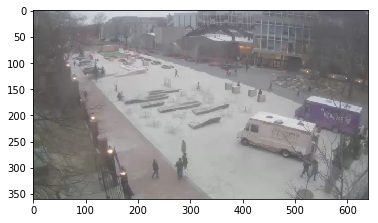

In [15]:
plt.imshow(frame)
plt.show()

In [16]:
output = sess.run(output_tensors, 
         feed_dict={input_tensor: np.expand_dims(frame, 0)})

In [21]:
bboxes, score, classes = output['bboxes'], output['scores'], output['classes']
bboxes = bboxes[score > 0.3]
classes = classes[score > 0.3]
score = score[score > 0.3]

In [22]:
def viz_image(image, bboxes):
    # Get the current reference
    h, w, _ = image.shape
    plt.imshow(image)
    ax = plt.gca()
    scaled_bboxes = bboxes * [h, w, h, w]
    for y1, x1, y2, x2 in scaled_bboxes:
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=1, edgecolor='r',
                             facecolor='none')
        ax.add_patch(rect)
    plt.show()

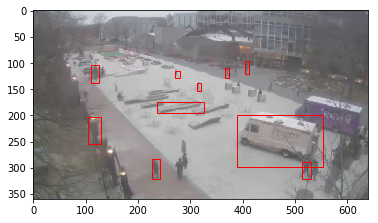

In [23]:
viz_image(frame, bboxes)

### Batching Frames

Can we batch multiple frames together for speedup?

In [24]:
BATCH_SIZE = 8
cap = cv2.VideoCapture(os.path.join(VIDEO_PATH, 'cs121lecture1.mp4'))
for _ in range(1000):
    cap.read()
    
frames = []
for _ in range(BATCH_SIZE):
    ret, frame = cap.read()
    frames.append(frame)

In [25]:
stacked_frames = np.stack(frames)
stacked_frames.shape

(8, 720, 1280, 3)

In [26]:
output = sess.run(output_tensors, 
         feed_dict={input_tensor: stacked_frames})
bboxes, score, classes = output['bboxes'], output['scores'], output['classes']

## Processing Entire Video

Now we process entire video and add the bboxes, scores, classes to a list.

In [27]:
def pred_from_frame(frames):
    """Takes a list of frames and runs it through our prediction"""
    frame = np.stack(frames)
    output = sess.run(output_tensors, 
         feed_dict={input_tensor: frame})
    bboxes, score, classes = output['bboxes'], output['scores'], output['classes']
    return bboxes, score, classes

In [43]:
import time
def process_video(video_path, batch_size=8, num_frames=None):
    cap = cv2.VideoCapture(video_path)
    processed = 0
    all_scores, all_classes, all_bboxes = [], [], []
    video_still_going = True
    start_time = time.time()
    while video_still_going:
        frames = []
        for _ in range(batch_size):
            ret, frame = cap.read()
            if not ret:
                print("Video finished")
                video_still_going = False
                break
            frames.append(frame)
        bboxes, scores, classes = pred_from_frame(frames)
        all_scores.append(scores)
        all_bboxes.append(bboxes)
        all_classes.append(classes)
        processed += batch_size
        if processed % 100 == 0:
            print("Processed {} frames\t\tTime Elapsed: {}".format(processed, time.time() - start_time)) 
        if num_frames and processed > num_frames:
            break
            
    print("Total time: {} seconds".format(int(time.time() - start_time)))
    return all_bboxes, all_scores, all_classes

In [44]:
os.listdir(VIDEO_PATH)

['scicenplaza_test.mkv', 'cs121lecture1.mp4', 'boazobfuscation.mp4']

In [45]:
TEST_VIDEO = os.path.join(VIDEO_PATH, 'scicenplaza_test.mkv')

In [77]:
bboxes, scores, classes = process_video(TEST_VIDEO, batch_size=48)

Processed 1200 frames		Time Elapsed: 68.45556306838989
Processed 2400 frames		Time Elapsed: 133.0087296962738
Processed 3600 frames		Time Elapsed: 196.7712881565094
Processed 4800 frames		Time Elapsed: 262.2147397994995
Processed 6000 frames		Time Elapsed: 328.645916223526
Processed 7200 frames		Time Elapsed: 395.09756731987
Processed 8400 frames		Time Elapsed: 461.8959698677063
Processed 9600 frames		Time Elapsed: 526.2322356700897
Processed 10800 frames		Time Elapsed: 590.3990535736084
Processed 12000 frames		Time Elapsed: 654.792638540268
Processed 13200 frames		Time Elapsed: 719.0233323574066
Processed 14400 frames		Time Elapsed: 783.0239443778992
Processed 15600 frames		Time Elapsed: 846.8788664340973
Processed 16800 frames		Time Elapsed: 910.6842920780182
Processed 18000 frames		Time Elapsed: 974.5988948345184
Processed 19200 frames		Time Elapsed: 1038.8602800369263
Processed 20400 frames		Time Elapsed: 1103.8989124298096
Processed 21600 frames		Time Elapsed: 1169.7812938690186
P

In [78]:
full_bboxes = np.row_stack(bboxes)
full_scores = np.row_stack(scores)
full_classes = np.row_stack(classes)

In [79]:
print(full_bboxes.shape)
print(full_scores.shape)
print(full_classes.shape)

(53118, 100, 4)
(53118, 100)
(53118, 100)


In [93]:
set(full_classes.flatten())

{1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 13.0,
 14.0,
 15.0,
 16.0,
 18.0,
 19.0,
 20.0,
 21.0,
 25.0,
 27.0,
 28.0,
 31.0,
 33.0,
 35.0,
 36.0,
 38.0,
 41.0,
 42.0,
 44.0,
 46.0,
 47.0,
 49.0,
 50.0,
 51.0,
 62.0,
 64.0,
 67.0,
 72.0,
 75.0,
 76.0,
 77.0,
 81.0,
 87.0,
 90.0}

In [80]:
full_bboxes[:, 1, :]
n = full_bboxes.shape[0]
center_of_mass = np.zeros((n, 2))

In [96]:
for index, bbox in enumerate(full_bboxes[:, 1, :]):
    if full_classes[index, 1] !=  1:
        continue
    y1, x1, y2, x2 = bbox
    center_of_mass[index, 0] = np.mean([x1, x2])
    center_of_mass[index, 1] = np.mean([y1, y2])

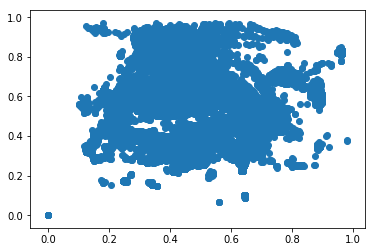

In [97]:
plt.scatter(center_of_mass[:, 0], center_of_mass[:, 1])
plt.show()

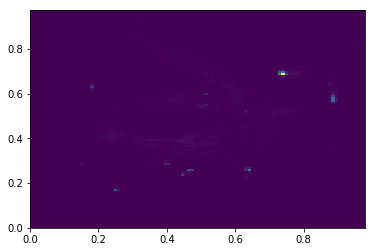

In [100]:
plt.hist2d(center_of_mass[:, 0], center_of_mass[:, 1], bins=100, cmap='viridis')
plt.show()

### Saving as PANDAS Dataframe and CSV

We will have to turn our detections into a list form for pandas, row by row.


In [99]:
import pandas as pd

In [84]:
from datetime import datetime
records = []
video_time = datetime.utcnow()
for index in range(full_bboxes.shape[0]):
    rec_bbox = full_bboxes[index]
    rec_scores = full_scores[index]
    rec_classes = full_classes[index]
    rec = [video_time, index, rec_bbox, rec_scores, rec_classes]
    records.append(rec)

In [85]:
a = pd.DataFrame(records)
a.columns = ["timestamp", "frame", "bboxes", "scores", "classes"]

In [86]:
a.to_csv("first_llorente_video.csv")